In [46]:
with open('data.txt','r') as f:
    raw_text = f.read()

In [47]:
print(raw_text[100:200])

in the United States and
most other parts of the world at no cost and with almost no restrictions
wh


In [48]:
print(f"Total Number of characters: {len(raw_text)}")

Total Number of characters: 92874


## Word Tokenization

In [49]:
import re
vocab = list(set([item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',raw_text) if item.strip()]))
vocab[:20]

['dang',
 'that;',
 ']',
 'gauded',
 'rest',
 'sense',
 'they',
 'aces',
 'SIMS',
 '“You--you',
 'anxious-like',
 'whatsoever',
 'yelpin',
 'stole',
 '“Two-bits',
 'sleeve',
 'Chamber',
 'Perkins',
 'see',
 'lemon']

In [50]:
## Creating token IDs
idx2str = {idx:token for idx,token in enumerate(vocab)}
idx2str[len(idx2str)] = "<UNK>"
idx2str[len(idx2str)] = "<|eot|>"
str2idx = {token:idx for idx,token in idx2str.items()}

print(f"Number of tokens::{len(idx2str)}")

Number of tokens::3361


In [51]:
## Creating a custom tokenizer class

class CustomTokenizerV1():
    def __init__(self, vocab, special_tokens = ["<|eot|>","<|cls|>","<|sep|>"]):
        self.idx2str = {idx:token for idx,token in enumerate(vocab)}
        ## adding special tokens
        self.idx2str[len(self.idx2str)] = "<|unk|>"
        for tok in special_tokens:
            self.idx2str[len(self.idx2str)] = tok
        self.str2idx = {token:idx for idx,token in self.idx2str.items()}
        assert len(self.idx2str) == len(self.str2idx)
        print(f"Total Number of tokens::{len(self.idx2str)}", end = "\n\n")
        print(f"-"*10 + " "+ "Special Tokens" + "-"*10, end = '\n\n')
        for tok in special_tokens:
            print(f"Token ID for {tok}::{self.str2idx[tok]}")

    def encode(self,seq):
        preprocessed = [item.strip() for item in re.split(r'([,.”?/()\'’]|\s)',seq) if item.strip()]
        tokenized = [self.str2idx.get(tok,self.str2idx.get("<|unk|>")) for tok in preprocessed]
        return tokenized

    def decode(self, tok_seq):
        text = ' '.join([self.idx2str.get(item) for item in tok_seq])
        text = re.sub(r'([,.”?/()\'’]|\s)',r'\1',text)
        return text


In [52]:
tokenizer = CustomTokenizerV1(vocab)
seq = "How are you doing charles?"
ids = tokenizer.encode(seq)
tokenizer.decode(ids)



Total Number of tokens::3363

---------- Special Tokens----------

Token ID for <|eot|>::3360
Token ID for <|cls|>::3361
Token ID for <|sep|>::3362


'How are you doing <|unk|> ?'

In [53]:
## using sub-word tokenization from tiktoken (Byte Pair Encoding)
import tiktoken
tokenizer_subword = tiktoken.get_encoding("gpt2")
seq = "How are you doing charles?<|endoftext|>"
ids = tokenizer_subword.encode(seq, allowed_special={"<|endoftext|>"})
for id_ in ids:
    print(tokenizer_subword.decode([id_]))


How
 are
 you
 doing
 char
les
?
<|endoftext|>


## BPE Encoding (Sub-Word Tokenization)

In [54]:

with open('data.txt','r') as f:
    raw_text = f.read()

encoded = tokenizer_subword.encode(raw_text)
print(f"Total number of tokens post encoding::{len(encoded)}")

Total number of tokens post encoding::29698


In [55]:
context_size = 5
X = encoded[:context_size]
y = encoded[1:context_size+1]
print(f"train samples::{X}")
print(f"test samples::{y}")

train samples::[464, 4935, 20336, 46566, 286]
test samples::[4935, 20336, 46566, 286, 1649]


## Creating DataLoader with Sub-Word tokenization

In [56]:
from typing import Any
from torch.utils.data import Dataset, DataLoader
from torch import tensor, arange

class GPTDatasetV1(Dataset):

    def __init__(self, txt, context_size, stride, tokenizer):
        self.input_ids = []
        self.output_ids = []
        ## tokenizing the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        ## looping over the sequences
        for i in range(0, len(token_ids) - context_size, stride):
            input_chunk = token_ids[i:i+context_size]
            target_chunk = token_ids[i+1:i+context_size+1]
            self.input_ids.append(tensor(input_chunk))
            self.output_ids.append(tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {"x":self.input_ids[idx],
                "y":self.output_ids[idx]}


def get_dataloader(txt, batch_size = 4, context_size = 1024, stride = 512,
                   shuffle = True, drop_last = True, num_workers = 0):
    '''Creates a dataloader object'''
    ## loading the sub-word tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    ## creating dataset oject
    dataset = GPTDatasetV1(txt, tokenizer=tokenizer,
                           context_size=context_size, stride=stride)
    ## creating the dataloader object
    dataloader = DataLoader(dataset,batch_size=batch_size,
                            drop_last=drop_last,
                            num_workers=num_workers,
                            shuffle = shuffle)
    return dataloader

In [57]:
loader = get_dataloader(raw_text, batch_size=8, 
                        context_size=1024, stride=512)


In [58]:
for batch in loader:
    print("Input Tensor",batch["x"],f"Input Tensor Shape::{batch['x'].shape}",sep = "\n")
    print("--"*10)
    print("Output Tensor",batch["y"],f"Output Tensor Shape::{batch['y'].shape}",sep = "\n")
    break

Input Tensor
tensor([[  257,   198, 45597,  ...,    13,   198,   198],
        [  247, 26569,   502,  ...,  1462,  3613,   465],
        [  251,   339,  4952,  ...,   220,   220,   220],
        ...,
        [   13,   198,   198,  ...,  5102,   880,   340],
        [ 6034,   259,   447,  ...,   564,   250,    40],
        [  464,  4935, 20336,  ...,   284,   198,  5796]])
Input Tensor Shape::torch.Size([8, 1024])
--------------------
Output Tensor
tensor([[  198, 45597,  1115,  ...,   198,   198, 13436],
        [26569,   502,   572,  ...,  3613,   465,   898],
        [  339,  4952,   514,  ...,   220,   220,   220],
        ...,
        [  198,   198,   447,  ...,   880,   340, 18959],
        [  259,   447,   247,  ...,   250,    40,  3088],
        [ 4935, 20336, 46566,  ...,   198,  5796,  2088]])
Output Tensor Shape::torch.Size([8, 1024])


## Token Embedding

In [59]:

from torch.nn import Embedding, LSTM, RNN
from torch.optim import Adam, RMSprop, SGD
vocab_size = tokenizer_subword.n_vocab
embedding_dim = 768

embedding_layer = Embedding(vocab_size, embedding_dim)
embedding_layer.weight.shape

torch.Size([50257, 768])

In [60]:
embedding_layer(tensor([[1,2,3, 9 ,8 ,22]])).shape

torch.Size([1, 6, 768])

In [61]:
embedding_layer(batch['x']).shape

torch.Size([8, 1024, 768])

## Positional Embedding/Encoding

In [62]:
## Positional Embeddings (Absolute Positional Encoding)
context_size = 1024
embedding_dim = 768
pos_embedding_layer = Embedding(context_size, embedding_dim)

In [63]:
pos_embedding_layer(arange(context_size)).shape

torch.Size([1024, 768])

In [64]:
embeddings = embedding_layer(batch['x'])
print(f"Embedding Shape::{embeddings.shape}")
pos_embeddings = pos_embedding_layer(arange(context_size))
print(f"Positional Embedding::{pos_embeddings.shape}")
final_input_embedding = embeddings + pos_embeddings
print(f"Embeddings + Positional Embedding::{final_input_embedding.shape}") # this will be the input to the self attention layer

Embedding Shape::torch.Size([8, 1024, 768])
Positional Embedding::torch.Size([1024, 768])
Embeddings + Positional Embedding::torch.Size([8, 1024, 768])


## Attention Mechanisms

### 1. Simplified Attention Mechanism **(No Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**

In [65]:
text = "I see skies of green, red roses too"
token_ids = tokenizer_subword.encode(text)

In [66]:
print(f"Token IDs::{token_ids}")
print(f"Decoded Token IDs::{tokenizer_subword.decode(token_ids)}")

Token IDs::[40, 766, 24091, 286, 4077, 11, 2266, 42152, 1165]
Decoded Token IDs::I see skies of green, red roses too


In [67]:
## Creating an embedding layer
VOCAB_SIZE = tokenizer_subword.n_vocab # Vocab Size of the sub-word tokenizer
EMBEDDING_SIZE = 3 # For Simplicity embedding each token into a 3-Dimensional Space
embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_SIZE)

In [68]:
## Creating Embedding of our tokens
embeddings = embedding_layer(tensor(token_ids))
embeddings.shape

torch.Size([9, 3])

In [69]:
embeddings = embeddings.detach().numpy().reshape(-1,3)
for emb, tok in zip(embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")



I --> [-0.21580641  0.975756    0.47101644]
see --> [-0.28212324 -1.111654    1.0423021 ]
skies --> [0.8164207 1.2088825 0.8007824]
of --> [ 1.1831362  -0.96956396  0.52328753]
green --> [ 1.1931348e-03 -1.2502908e+00 -1.3024205e+00]
, --> [ 1.0896317  1.2804916 -2.2520337]
red --> [ 1.0780582 -2.7104557  2.6207783]
roses --> [-1.542924  -1.2473693 -0.8555016]
too --> [-1.4136536   2.207096    0.40790978]


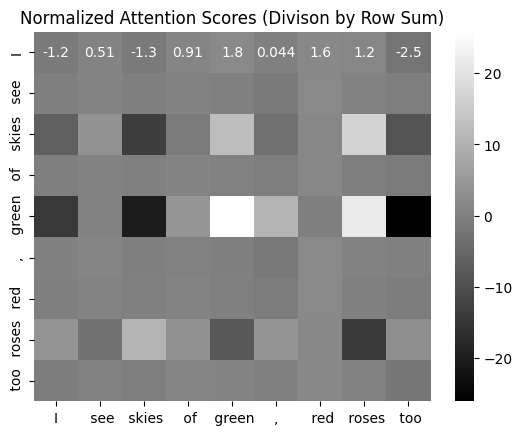

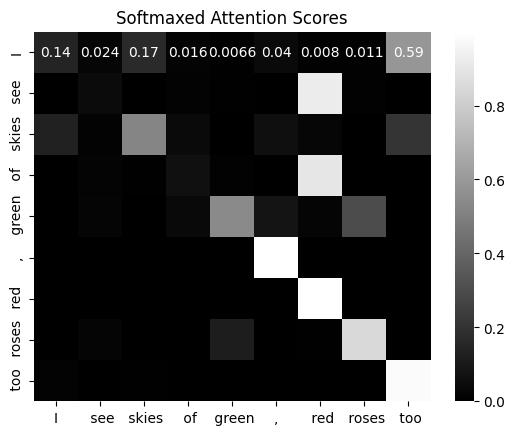

In [70]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def softmax(mat):
    '''Softmax as implemented in pytorch'''
    num_ =  np.exp(mat-np.max(mat, axis=1, keepdims=True))
    denom_ = np.sum(num_, axis=1, keepdims=True)
    return num_/denom_


labels = [tokenizer_subword.decode([i]) for i in token_ids]
attention_scores = embeddings @ embeddings.T
# Normalizing the attention scores by dividing by sum of the corresponding rows
normalized_attention_scores = attention_scores/np.sum(attention_scores, axis=1, keepdims=True)
## Plotting the HeatMap for the Normalized Attention Scores
sns.heatmap(normalized_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Normalized Attention Scores (Divison by Row Sum)")
plt.show();

softmaxed_attention_scores = softmax(attention_scores)
sns.heatmap(softmaxed_attention_scores, annot=True, cmap='gray',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Softmaxed Attention Scores")
plt.show();

In [71]:
context_embeddings = softmaxed_attention_scores @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb}")

I --> [-0.6807164  1.5986687  0.3854805]
see --> [ 0.983025  -2.5734742  2.4586139]
skies --> [0.24086633 1.1604756  0.519264  ]
of --> [ 1.0451578 -2.5246925  2.4040747]
green --> [-0.31904456 -1.0532583  -1.0386494 ]
, --> [ 1.0858649  1.2767495 -2.2457008]
red --> [ 1.077996  -2.7103057  2.6206145]
roses --> [-1.3101115 -1.2294091 -0.8440317]
too --> [-1.383528    2.1835353   0.40712804]


#### Same stuff but using pytorch

In [72]:
import torch
attn_scores = embeddings @ embeddings.T
attn_weights = torch.softmax(tensor(attn_scores), dim = -1)
context_embeddings = attn_weights @ embeddings
for emb, tok in zip(context_embeddings,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

I --> [-0.68071645  1.5986689   0.38548052]
see --> [ 0.983025  -2.5734742  2.4586139]
skies --> [0.24086635 1.1604756  0.519264  ]
of --> [ 1.0451577 -2.524692   2.4040742]
green --> [-0.31904456 -1.0532583  -1.0386494 ]
, --> [ 1.0858649  1.2767495 -2.2457008]
red --> [ 1.077996  -2.7103057  2.6206145]
roses --> [-1.3101115 -1.2294091 -0.8440317]
too --> [-1.3835282  2.1835356  0.4071281]


#### We observe our calculations give us similar results

#### Why the need for Trainable Weights?

### 2. Self Attention Mechanism **(With Trainable Weights)**
- Converting **Embedding Vectors** to **Context Vectors**
- Creating *Query*, *Key* and *Value* matrices **(Trainable Weights)**

In [73]:
torch.manual_seed(123)
d_in = EMBEDDING_SIZE
d_out = 2
w_Q = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Query Weight Matrix
w_K = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Key Weight Matrix
w_V = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)# Value Weight Matrix

In [74]:
embeddings_tensors = tensor(embeddings)

In [75]:
query = embeddings_tensors @ w_Q
key = embeddings_tensors @ w_K
value = embeddings_tensors @ w_V
query

tensor([[ 0.2165,  0.9685],
        [-0.2862, -0.0080],
        [ 0.6052,  1.9480],
        [ 0.1450,  0.3970],
        [-0.4107, -1.9889],
        [ 0.4783, -0.5069],
        [-0.1691,  0.9615],
        [-0.8341, -2.3972],
        [ 0.1670,  1.1429]])

#### Can also be done in a different way

In [76]:
## concating query, key and value weights horizontally
q_k_v = torch.concat([w_Q,w_K,w_V], dim = -1)
print(f"Inputs shape::{embeddings_tensors.shape}")
print(f"q_k_v shape::{q_k_v.shape}")
outputs = embeddings_tensors@q_k_v
print(f"Outputs shape::{outputs.shape}")

Inputs shape::torch.Size([9, 3])
q_k_v shape::torch.Size([3, 6])
Outputs shape::torch.Size([9, 6])


In [77]:
query_new, key_new, value_new = torch.hsplit(outputs,3)
query_new==query

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])

In [78]:
attn_scores = query_new @ key_new.T
scaled_attn_scores = attn_scores/torch.math.sqrt(w_K.shape[-1]) ## scaled attention scores
attn_weights = torch.softmax(scaled_attn_scores, dim = -1)

context_vectors = attn_weights @ value_new

print("Context Vectors", end = "\n")
print("--"*10, end='\n\n')
for emb, tok in zip(context_vectors,token_ids):
    print(f"{tokenizer_subword.decode([tok]).strip()} --> {emb.detach().numpy()}")

Context Vectors
--------------------

I --> [0.28195983 0.72027934]
see --> [-0.05978425 -0.03109078]
skies --> [0.466063  0.9751878]
of --> [0.1117409 0.4106027]
green --> [-0.48244157 -1.2769953 ]
, --> [-0.15186125 -0.1552704 ]
red --> [0.2614793 0.6526389]
roses --> [-0.52076316 -1.4081876 ]
too --> [0.3217991 0.776334 ]


#### Why we divide the attention scores by sqrt(key dimension)?
1. **Stability in Learning**

### Causal Attention Layer

In [79]:
CONTEXT_SIZE = 5
inp_text = "Hello How are you?"
embedding_layer = Embedding(tokenizer_subword.n_vocab, 768)
pos_embedding_layer = Embedding(CONTEXT_SIZE, 768)
inp_tok =tokenizer_subword.encode(inp_text)
embeddings = embedding_layer(tensor([inp_tok]))
pos_emb = pos_embedding_layer(torch.arange(tensor(embeddings.shape[1])))
inp_embedding = embeddings + pos_emb


In [80]:
class CausalAttention(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length,
                 dropout = 0, q_k_v_bias = False,
                 causal_mask = True):
        super().__init__()
        self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.dropout = torch.nn.Dropout(dropout)
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        # batch, seq_len, d_in = x.shape
        q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        # print(f"q_k_v shape: {q_k_v.shape}")
        combined_transform = x @ q_k_v
        # print(f"combined_transform shape: {combined_transform.shape}")
        query, key, value = torch.split(combined_transform,self.W_key.shape[-1], dim=2)
        attn_weights = query @ key.transpose(1,2) # (batch X seq_len X seq_len)
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)
        scaled_attn_weights = attn_weights/key.shape[-1]**0.5
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))
        return {"context_vectors": attn_scores @ value,
                "attn_scores": attn_scores} # context rich vectors (batch X seq_len X embedding_dim)


In [81]:
# inp_embedding = torch.concat([inp_embedding]*5, dim = 0)
c_attn = CausalAttention(*(768,768,5), causal_mask=True)
# c_attn(inp_embedding)

In [82]:
for param in c_attn.parameters():
    print(param.shape)

torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])


In [83]:
c_attn(inp_embedding)

{'context_vectors': tensor([[[  2.3038,  -6.3534,   0.2914,  ...,  -6.2244,   9.5452,  -8.3201],
          [  2.3038,  -6.3534,   0.2914,  ...,  -6.2244,   9.5452,  -8.3201],
          [ 37.6857,  25.8231,  17.3346,  ...,  21.4372,  28.7299,  36.8135],
          [ 37.6857,  25.8231,  17.3346,  ...,  21.4372,  28.7299,  36.8135],
          [-34.3452, -44.6836, -41.2677,  ..., -44.9336, -21.9690, -32.7346]]],
        grad_fn=<UnsafeViewBackward0>),
 'attn_scores': tensor([[[1., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)}

### Muti Head Attention

In [84]:
## applies heads sequentially
class MultiHeadAttentionWrapper(torch.nn.Module):
    def __init__(self, d_in, d_out,context_length, num_heads, dropout = 0.0, q_k_v_bias = False):
        super().__init__()
        self.heads = torch.nn.ModuleList([CausalAttention(d_in, d_out,context_length) for _ in range(num_heads)])
    def forward(self, x):
        return torch.concat([head(x)['context_vectors'] for head in self.heads], dim=-1)


In [85]:
multi_attn = MultiHeadAttentionWrapper(768,3,5,10, dropout=0.5)

In [86]:
out_ = multi_attn(inp_embedding)
out_.shape

torch.Size([1, 5, 30])

#### Improving the MultiHead Attention By implementing the heads parallely

In [87]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads,dropout = 0.0, causal_mask = True):
        super().__init__()
        self.num_heads = num_heads
        self.d_out = d_out
        self.W_query = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, num_heads * d_out, dtype=torch.float32))
        self.dropout = torch.nn.Dropout(dropout)
        self.out_project = torch.nn.Parameter(torch.rand(num_heads *d_out, d_out, dtype=torch.float32))
        self.causal_mask = causal_mask
        self.register_buffer('mask', torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        # q_k_v =  torch.concat([self.W_query,self.W_key,self.W_value],dim = -1)
        queries = x @ self.W_query
        keys = x @ self.W_key
        values = x @ self.W_value

        # Reshape for multi-head attention
        queries = queries.view(batch_size, seq_len, self.num_heads, self.d_out)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.d_out)
        values = values.view(batch_size, seq_len, self.num_heads, self.d_out)

        # Transpose the shapes (Grouping with respect to number of heads)
        queries = queries.transpose(1,2)# (batch X num_heads X seq_len X d_out)
        keys = keys.transpose(1,2)# (batch X num_heads X seq_len X d_out)
        values = values.transpose(1,2)# (batch X num_heads X seq_len X d_out)

        # Calculating Attention Scores
        attn_weights = queries @ keys.transpose(2,3) # (batch X num_heads X seq_len X seq_len)

        # Adding the Causal Mask
        if self.causal_mask:
            attn_weights = attn_weights.masked_fill(self.mask.bool(),-torch.inf)# (batch X num_heads X seq_len X seq_len)

        # Scaling and Softmax the atten scores
        scaled_attn_weights = attn_weights/keys.shape[-1]**0.5# (batch X num_heads X seq_len X seq_len)
        attn_scores = self.dropout(torch.softmax(scaled_attn_weights, dim=-1))# (batch X num_heads X seq_len X seq_len)
        context_vectors = (attn_scores @ values).transpose(1,2)# (batch X seq_len X num_heads X d_out)
        concated_context_vectors = context_vectors.contiguous().view(batch_size,seq_len,-1)# (batch X seq_len X num_heads * d_out)
        context_vectors = concated_context_vectors @ self.out_project# (batch X seq_len X d_out)
        return {"context_vectors": context_vectors,
                "attn_scores": attn_scores} # context vectors (batch X seq_len X embedding_dim)
                                            # attn_scores (batch X num_heads X seq_len X seq_len)



In [92]:
inp_embedding.shape

torch.Size([1, 5, 768])

In [98]:
# making batch size = 5
inp_embedding_new = torch.concat([inp_embedding]*10, dim =0)
inp_embedding_new += torch.rand(size = (inp_embedding_new.shape)) # making values in each batch different
inp_embedding_new.shape

torch.Size([10, 5, 768])

In [101]:
multi_attn = MultiHeadAttention(d_in=768,
                                d_out = 751,
                                num_heads=2,
                                context_length=5,
                                dropout=0.4)

In [102]:
multi_attn(inp_embedding_new)['context_vectors'].shape

torch.Size([10, 5, 751])

In [103]:
multi_attn(inp_embedding_new)['attn_scores'].shape

torch.Size([10, 2, 5, 5])